In [1]:
import torch
import torch.nn as nn
from d2l import torch as d2l

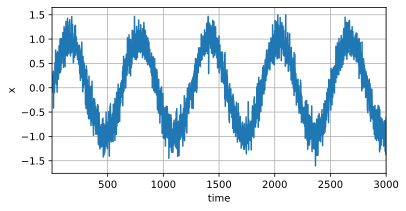

In [3]:
# Generating 3000 synthetic data follow sin function and add additive noise

class Data(d2l.DataModule):
    def __init__(self, batch_size=16, T=3000, num_train=600, tau=4):
        self.save_hyperparameters()
        self.time = torch.arange(1, T+1, dtype=torch.float32)
        self.x = torch.sin(0.01 * self.time) + torch.randn(T) * 0.2

data = Data()
d2l.plot(data.time, data.x, 'time', 'x', xlim=[1, 3000], figsize=(6, 3))

In [4]:
@d2l.add_to_class(Data)
def get_dataloader(self, train):
    features = [self.x[i : self.T - self.tau + i] for i in range(self.tau)]
    self.features = torch.stack(features, 1)
    self.labels = self.x[self.tau:].reshape((-1, 1))
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader([self.features, self.labels], train, i)

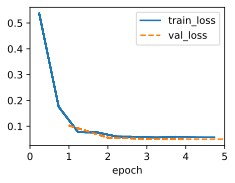

In [5]:
model = d2l.LinearRegression(lr=0.01)
trainer = d2l.Trainer(max_epochs=5)
trainer.fit(model, data)

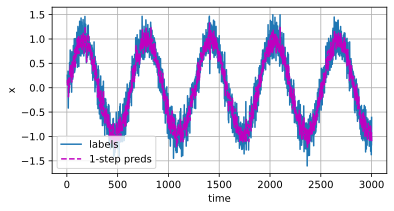

In [6]:
## Prediction

onestep_preds = model(data.features).detach().numpy()
d2l.plot(data.time[data.tau:], [data.labels, onestep_preds], 'time', 'x', legend=['labels', '1-step preds'], figsize=(6, 3))

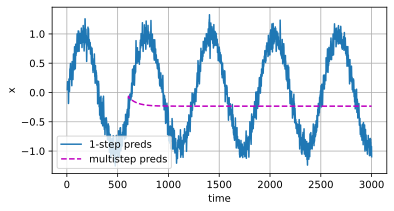

In [7]:
multistep_preds = torch.zeros(data.T)
multistep_preds[:] = data.x
for i in range(data.num_train + data.tau, data.T):
    multistep_preds[i] = model(
        multistep_preds[i - data.tau:i].reshape((1, -1)))
multistep_preds = multistep_preds.detach().numpy()

d2l.plot([data.time[data.tau:], data.time[data.num_train+data.tau:]],[onestep_preds, multistep_preds[data.num_train+data.tau:]], 'time',
         'x', legend=['1-step preds', 'multistep preds'], figsize=(6, 3))

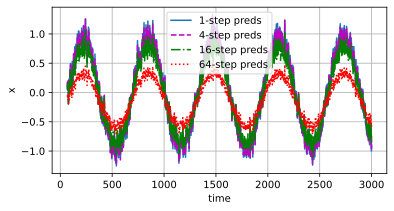

In [8]:
def k_step_pred(k):
    features = []
    for i in range(data.tau):
        features.append(data.x[i : i+data.T-data.tau-k+1])
    for i in range(k):
        preds = model(torch.stack(features[i : i+data.tau], 1))
        features.append(preds.reshape(-1))
    return features[data.tau:]

steps = (1, 4, 16, 64)
preds = k_step_pred(steps[-1])
d2l.plot(data.time[data.tau+steps[-1]-1:],
         [preds[k - 1].detach().numpy() for k in steps], 'time', 'x', legend=[f'{k}-step preds' for k in steps], figsize=(6, 3))

## Text Sequence

In [9]:
import collections
import re

In [10]:
## Reading the dataset
class TimeMachine(d2l.DataModule):
    def _download(self):
        fname = d2l.download(d2l.DATA_URL + 'timemachine.txt', self.root, '090b5e7e70c295757f55df93cb0a180b9691891a')
        with open(fname) as f:
            return f.read()
        
data = TimeMachine()
raw_text = data._download()
raw_text[:60]

'The Time Machine, by H. G. Wells [1898]\n\n\n\n\nI\n\n\nThe Time Tra'

In [11]:
# Ignoring punctuation and capitalization

@d2l.add_to_class(TimeMachine)
def _preprocess(self, text):
    return re.sub('[^A-Za-z]+', ' ', text).lower()

text = data._preprocess(raw_text)
text[:60]

'the time machine by h g wells i the time traveller for so it'

In [13]:
## Tokenization
@d2l.add_to_class(TimeMachine)
def _tokenize(self, text):
    return list(text)

tokens = data._tokenize(text)
','.join(tokens[:30])

't,h,e, ,t,i,m,e, ,m,a,c,h,i,n,e, ,b,y, ,h, ,g, ,w,e,l,l,s, '

In [14]:
## Vocabulary
class Vocab:
    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
        if tokens and isinstance(tokens[0], list): # Flattens the list of lists into a single list
            tokens = [token for line in tokens for token in line]
        
        counter = collections.Counter(tokens) # Counts the freuency of each token
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1], reverse=True) # Sorts the freq in descending order

        # Creates sorted list of unique tokens based on their freq (should be greater than or equal to min_freq)
        self.idx_to_token = list(sorted(set(['<unk>'] + reserved_tokens + [token for token, freq in self.token_freqs if freq >= min_freq])))
        self.token_to_idx = {token: idx for idx, token in enumerate(self.idx_to_token)} # maps tokens to corresponding indices

    def __len__(self):
        return len(self.idx_to_token)
    
    # Retrieves indices or list of indices for tokens or list of tokens
    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]
    
    # Returns corr tokens for provided indices either as single token or list of tokens 
    def to_tokens(self, indices):
        if hasattr(indices, '__len__') and len(indices) > 1:
            return [self.idx_to_token[int(index)] for index in indices]
        return self.idx_to_token[indices]

    @property
    def unk(self):
        return self.token_to_idx['<unk>'] # If not in vocab returns unk
    
vocab = Vocab(tokens)
indices = vocab[tokens[:10]]
print('indices:', indices)
print('words:', vocab.to_tokens(indices))

indices: [21, 9, 6, 0, 21, 10, 14, 6, 0, 14]
words: ['t', 'h', 'e', ' ', 't', 'i', 'm', 'e', ' ', 'm']


In [15]:
@d2l.add_to_class(TimeMachine)  
def build(self, raw_text, vocab=None):
    tokens = self._tokenize(self._preprocess(raw_text))
    if vocab is None: vocab = Vocab(tokens)
    corpus = [vocab[token] for token in tokens]
    return corpus, vocab

corpus, vocab = data.build(raw_text)
len(corpus), len(vocab)

(173428, 28)

[('the', 2261), ('i', 1267), ('and', 1245), ('of', 1155), ('a', 816), ('to', 695), ('was', 552), ('in', 541), ('that', 443), ('my', 440)]


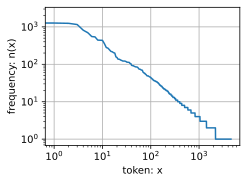

In [16]:
## Printing the 10 most frequently occuring words

words = text.split()
vocab = Vocab(words)
print(vocab.token_freqs[:10])

## Plotting 
freqs = [freq for token, freq in vocab.token_freqs]
d2l.plot(freqs, xlabel='token: x', ylabel='frequency: n(x)', xscale='log', yscale='log')

In [17]:
## Inspecting ten most frequent word pairs

bigram_tokens = ['--'.join(pair) for pair in zip(words[:-1], words[1:])]
bigram_vocab = Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[('of--the', 309),
 ('in--the', 169),
 ('i--had', 130),
 ('i--was', 112),
 ('and--the', 109),
 ('the--time', 102),
 ('it--was', 99),
 ('to--the', 85),
 ('as--i', 78),
 ('of--a', 73)]

In [18]:
## Inspecting the most frequent three words pairs

trigram_tokens = ['--'.join(triple) for triple in zip(
    words[:-2], words[1:-1], words[2:])]
trigram_vocab = Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[('the--time--traveller', 59),
 ('the--time--machine', 30),
 ('the--medical--man', 24),
 ('it--seemed--to', 16),
 ('it--was--a', 15),
 ('here--and--there', 15),
 ('seemed--to--me', 14),
 ('i--did--not', 14),
 ('i--saw--the', 13),
 ('i--began--to', 13)]

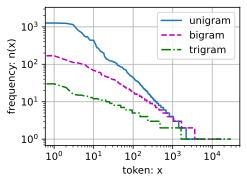

In [19]:
## Visualizing the frequency

bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
d2l.plot([freqs, bigram_freqs, trigram_freqs], xlabel='token: x',
         ylabel='frequency: n(x)', xscale='log', yscale='log',
         legend=['unigram', 'bigram', 'trigram'])